In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/Colab Notebooks/RL in QEC")

In [3]:
from jax_exp_env import flip,get_actions,rho_n,jax_exp_env,jtensor

from model import *
from utils import *
from nac import train_model_pg

from collections import deque
import torch
import torch.optim as optim
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm


''' ENVIRONMENT'''
num_qubit = 4 # 1,2,3,4
T_dec = 1200
Gamma = 1/T_dec
num_substep = 2
gate_first = True
hparam={'P':0.1}
pparam={'Tsingle':T_dec}
solver_args = {'atol':1e-8,'rtol':1e-8,'method':'adam','order':12}

# Define the set of available actions
actions = get_actions(num_qubit)
print(actions.keys())

# Define the initial state
rho = [ rho_n(n,num_qubit) for n in [[0,0,0],[1,0,0],[0,1,0],[0,0,1]] ] #rho0,1,2,3
    
# Define the quantum evolution
Ls = [jnp.array(np.sqrt(Gamma)*flip(num_qubit,i,'x')) for i in range(num_qubit)]
L_daggers = [l.T.conj() for l in Ls]
L_daggerLs = jnp.sum(jnp.array([l_dagger.dot(l) for l_dagger,l in zip(L_daggers,Ls)]), axis=0)

LLconj = jnp.sum(jnp.array([jtensor([l,l.conj()]) for l in Ls]), axis=0)
LdLI = jtensor([L_daggerLs,jnp.eye(2**num_qubit)])
ILdL = jtensor([jnp.eye(2**num_qubit),L_daggerLs.T])
expD = expm(LLconj - 0.5*LdLI - 0.5*ILdL)

dict_keys(['M0', 'M1', 'M2', 'M3', 'CNOT01', 'CNOT02', 'CNOT03', 'CNOT10', 'CNOT12', 'CNOT13', 'CNOT20', 'CNOT21', 'CNOT23', 'CNOT30', 'CNOT31', 'CNOT32', 'X0', 'X1', 'X2', 'X3', 'I'])


In [4]:
# Change batch_size
batch_size = 64
num_step = 200
gamma = 0.95
rho_batch = np.array([rho for i in range(batch_size)])
env = jax_exp_env(num_qubit, rho_batch, expD, actions, num_step, 
               num_substep, hparam, pparam, solver_args)
state = env.reset()

def protocol(initial,repeat,num_step):
    iteration = int(np.ceil((num_step-len(initial))/len(repeat)))
    protocol = initial + repeat*iteration
    return protocol[:num_step]
repeat = [1,5,10,20,50]
detect_data = np.array([protocol([6, 5, 4]+i*[9, 3, 6, 12, 3, 6],[20],num_step) for i in repeat])

Running on device:  cuda:0


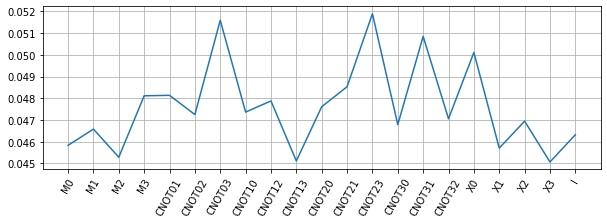

In [5]:
'''RL'''
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: ',  device)

pca = 0
num_action = len(actions)
a_nin = 4*2*2**num_qubit*pca + 3 + num_action + 1
a_hid = 300
init_scale = 1
init_kind = 'uniform'

actor = Actor_FNN((a_nin,num_action,a_hid)).to(device)

reset_plot = True

state = env.reset()    
_,state = preprocess_jax(state,num_action,order=pca)
policy = actor(state.to(device))
    
plot_policy(policy.mean(0).cpu().detach().numpy(),actions)

In [6]:
# %%prun -s cumulative -q -l 30 -T prun0
# Training args
num_ep = 1500
a_lr = 0.0024 #*np.sqrt(10)
gamma = 0.95
kappa = 0.9
cg_tol = 1e-10
order = 2
inject = 0.01
nsteps = 20
method = 'cg'
shift = 1e-4
p_inject = np.hstack([1-inject,np.array([0.04,0.03,0.03,0.03,0.02])*inject/0.15])
optimizer='gd'
name = f'jaxexp_pg_batch{batch_size}_lr{a_lr}_{method}_nsteps{nsteps}_shift{shift}_pca{pca}_seed{seed}'
print(name)
eff_lr = False
load = False
bias = True
signal_seqs = []

if reset_plot:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if optimizer=='adam-manual':
        a_opt = adam_opt(a_lr)
    else:
        a_opt = optim.Adam(actor.parameters(), lr=a_lr)
    if load:
        checkpoint = torch.load(f'models/{name}.pt',map_location=device)
        ep_start = checkpoint['epoch']
        actor.load_state_dict(checkpoint['actor_state_dict'])
        a_opt.load_state_dict(checkpoint['a_opt_state_dict'])
        baseline = checkpoint['baseline'].cpu()
        plot_data = list(np.loadtxt(f'plots/{name}.csv'))
    else:
        baseline = torch.zeros(num_step)
        print(baseline.sum())
        plot_data = []
        ep_start = 0
        # torch.save({'actor_state_dict': actor.state_dict(),
        #             'a_opt_state_dict': a_opt.state_dict()},
        #             f'models/{name}_init.pt')
    reset_plot = False

for ep in range(ep_start,ep_start+num_ep):
    # -------------------------------------------
    # step 1: generate data: critic_states, returns, log_probs for actor
    actor.train()
    states = []
    log_probs = []
    policies = []
    revealed = []
    
    state = env.reset()    
    _,state = preprocess_jax(state,num_action,bias=bias,order=pca)
    
    rewards = []
    act_seq = []
    ind1 = []
    signals = 0
    # cond = np.random.choice(6,batch_size,p=p_inject)
    cond = np.random.choice(1,batch_size)
    for t in range(num_step):
        
        policy = actor(state.to(device)) # add and remove seqence length dim
        action = random_choice_2d(policy.cpu().detach().numpy())
        action = np.where(cond>0,detect_data[cond-1,t],action)
       
        log_probs.append(torch.log(np.take_along_axis(policy,action[...,None],axis=-1)))
        policies.append(policy)
        revealed.append(env.revealed.astype(int))

        new_state, reward, done = env.step(action)
        
        states.append(state)
        _,state = preprocess_jax(new_state,num_action,bias=bias,order=pca)
        rewards.append(reward)
        act_seq.append(action)
        
    mask = (1-np.array(revealed)).T # (batch,time)
    rewards = np.moveaxis(np.array(rewards),0,-1) # (time,2,batch)->(2,batch,time)
    assert not (mask*rewards-rewards).any()
    returns = get_returns(rewards,gamma) # (batch,time)
    baseline = get_baseline(returns,kappa,baseline)
    policies = torch.stack(policies).transpose(0,1)
    states = torch.stack(states).transpose(0,1)
    log_probs = torch.stack(log_probs).transpose(0,1).squeeze()
    
    sum_returns = returns.cpu().numpy().sum(-1)
    if (sum_returns>117.499).any():
        ind1 = np.where(sum_returns>117.499)[0]
        if (env.rq[ind1]>0.89).any():
            ind2 = np.where(env.rq[ind1]>0.89)[0]
            signals = len(ind1[ind2])

    if (sum_returns>177.1).any():
        ind = np.where(sum_returns>177.1)[0]
        signal_seq = np.array(act_seq)[:,ind].T
        print(sum_returns[ind],signal_seq)
        signal_seqs.append(signal_seq)
  
    memory = [policies, states, returns-baseline, log_probs]
    # -------------------------------------------
    # step 2: train model
    data = train_model_pg(actor, memory,a_lr,a_opt,order,optimizer,device,cg_tol,eff_lr,nsteps,method,shift)
    plot_data.append([returns.cpu().numpy().sum()/batch_size, mask.sum(-1).mean(), env.rq.mean()] + data[:-5] + [signals, sum_returns.max()] + data[-5:-1]+ [baseline.cpu().sum().item()])
    try:
        print(f'Ep {ep+1}, rq: {plot_data[-1][2]:.3e}, return: {plot_data[-1][0]:.3f}, loss: {plot_data[-1][3]:.1e}, entropy: {plot_data[-1][5]:.2e}, gvan_err: {plot_data[-1][11]:.2e}. Inject: {(cond>0).sum()}, signals: {signals:02}. Max return: {sum_returns[ind1][ind2].max():.3f}')
    except:
        print(f'Ep {ep+1}, rq: {plot_data[-1][2]:.3e}, return: {plot_data[-1][0]:.3f}, loss: {plot_data[-1][3]:.1e}, entropy: {plot_data[-1][5]:.2e}, gvan_err: {plot_data[-1][11]:.2e}. Inject: {(cond>0).sum()}, signals: 00.')    
  
    if np.isnan(data[0]):
        print('NaN encountered')
        break
    if (ep+1)%10==0:
        np.savetxt(f'plots/{name}.csv',np.array(plot_data))
        torch.save({'epoch':ep+1,
                    'baseline':baseline,
                    'actor_state_dict': actor.state_dict(),
                    'a_opt_state_dict': a_opt.state_dict()},
                    f'models/{name}.pt')

    # if (ep+1) in np.hstack([[1],np.arange(10,51,10),np.arange(100,501,50),np.arange(1000,3001,500)]):
    # # [   1,   10,   20,   30,   40,   50,  100,  150,  200,  250,  300,   350,  400,  450,  500, 1000, 1500, 2000, 2500, 3000]
    #     pol = policies.cpu().detach().numpy()[None,...]
    #     if (ep+1)>1:
    #         old_pol = np.load(f'plots/{name}.npy')
    #         pol = np.vstack([old_pol,pol])
    #     np.save(f'plots/{name}.npy',pol)
            
    if (ep+1)%50==0:
        plot_pg(np.array(plot_data))            
plot_pg(np.array(plot_data))
ep_start = ep + 1
print(signal_seqs)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(open('prun0', 'r').read())

         8277307 function calls (8161125 primitive calls) in 42.342 seconds

   Ordered by: cumulative time
   List reduced from 2336 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   42.368   42.368 {built-in method builtins.exec}
        1    0.055    0.055   42.367   42.367 <string>:3(<module>)
      400    0.032    0.000   21.354    0.053 jax_exp_env.py:122(step)
      400    0.683    0.002   17.316    0.043 jax_exp_env.py:156(gate_operation)
        2    0.015    0.007   16.412    8.206 nac.py:141(train_model_pg)
       50   15.670    0.313   15.670    0.313 {method 'run_backward' of 'torch._C._EngineBase' objects}
       48    0.001    0.000   15.341    0.320 __init__.py:135(grad)
        2    0.015    0.007   13.826    6.913 nac.py:31(conjugate_gradient)
    18884    0.275    0.000   13.650    0.001 api.py:190(f_jitted)
       40    0.523    0.013   13.575    0.339 nac.py:22(fisher_vector_product)

In [ ]:
print(open('prun0', 'r').read())

         7744285 function calls (7627720 primitive calls) in 62.264 seconds

   Ordered by: cumulative time
   List reduced from 2337 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   62.302   62.302 {built-in method builtins.exec}
        1    0.062    0.062   62.301   62.301 <string>:3(<module>)
        2    0.004    0.002   34.330   17.165 nac.py:141(train_model_pg)
       50   33.174    0.663   33.174    0.663 {method 'run_backward' of 'torch._C._EngineBase' objects}
       48    0.001    0.000   32.501    0.677 __init__.py:135(grad)
        2    0.070    0.035   29.352   14.676 nac.py:31(conjugate_gradient)
       40    0.840    0.021   28.643    0.716 nac.py:22(fisher_vector_product)
      400    0.041    0.000   23.323    0.058 jax_exp_env.py:122(step)
      400    0.007    0.000   10.588    0.026 jax_exp_env.py:217(dissipative_dynamics)
      799    0.069    0.000   10.470    0.013 jax_exp_env.py

In [ ]:
def num_epoch(batch_size,num_step,hours):
    return hours*3600/(0.0017*num_step*batch_size)
hours = 9
num_epoch(batch_size,num_step,hours)

1488.9705882352941

In [ ]:
163.570/5

32.714

In [ ]:
print(open('prun0', 'r').read())

         15226820 function calls (15099833 primitive calls) in 67.325 seconds

   Ordered by: cumulative time
   List reduced from 2385 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   67.362   67.362 {built-in method builtins.exec}
        1    0.080    0.080   67.361   67.361 <string>:3(<module>)
      600    0.070    0.000   43.418    0.072 jax_exp_env.py:122(step)
      600    1.778    0.003   33.676    0.056 jax_exp_env.py:156(gate_operation)
    45393    0.653    0.000   25.190    0.001 api.py:190(f_jitted)
    45393    0.152    0.000   21.021    0.000 core.py:1173(bind)
    45393    0.482    0.000   20.870    0.000 core.py:1157(call_bind)
        3    0.012    0.004   19.196    6.399 nac.py:147(train_model_pg)
    45393    0.041    0.000   18.527    0.000 core.py:1176(process)
    45393    0.086    0.000   18.486    0.000 core.py:575(process_call)
    45393    0.482    0.000   18.400    0.000 xla

In [ ]:
print(open('prun0', 'r').read())

         23041398 function calls (22895696 primitive calls) in 78.599 seconds

   Ordered by: cumulative time
   List reduced from 2030 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001   78.600   78.600 {built-in method builtins.exec}
        1    0.085    0.085   78.600   78.600 <string>:3(<module>)
     1000    0.085    0.000   68.885    0.069 jax_exp_env.py:122(step)
     1000    2.212    0.002   55.024    0.055 jax_exp_env.py:156(gate_operation)
    77106    0.989    0.000   41.369    0.001 api.py:186(f_jitted)
    77106    0.260    0.000   35.035    0.000 core.py:1143(bind)
    77106    0.822    0.000   34.774    0.000 core.py:1127(call_bind)
    77106    0.079    0.000   30.595    0.000 core.py:1146(process)
    77106    0.168    0.000   30.515    0.000 core.py:576(process_call)
    77106    0.890    0.000   30.347    0.000 xla.py:528(_xla_call_impl)
    77106   16.425    0.000   25.653    0.000 xla